In [120]:
%config IPCompleter.greedy=True
#%matplotlib inline
%matplotlib notebook
#%matplotlib widget # for ipympl (needs jupyterlab etc.)

import os, glob
from lammps_multistate_rods.tools.clusters import read_cluster_data, composition_by_states

import numpy as np
from scipy.stats import linregress
from scipy.optimize import curve_fit
import scipy.odr

from matplotlib import pyplot as plt
#from mpl_toolkits import mplot3d
from matplotlib import cm

def calc_c(number, volume):
    '''
    Concentration in mM/L for volume in nm^3
    '''
    return (10000.0*number)/(6.022*volume)

def lin_fit_func(x, a, b):
    return a*x + b

def growth_fit_func(params, c):
    return params[1]*c/(c + params[0])

def nucl_fit_func(params, logc):
    return params[0]*logc + params[1]

data_dir = '/media/data_ntfs/PhD/projects/amyloid MD simulations/data/growth/5p_v3/'
#data_dir += 'benchmarks/'
data_dir += '3.25-1.00-4.00-1.50_7.50-2.00_4.50-mu_20'

In [148]:
# get all the data into appropriate structures

filepaths = sorted(glob.glob(os.path.join(data_dir, '*_cluster_data')))
n_sims = len(filepaths)

cell_sizes = set()
nums_cells = set()
all_data = {}
data_struct = ['ts', 'Vs', 'growth_raw', 'growth_clean', 'Nsol', 'Nbeta', 'Nfibs']
for n in range(n_sims):
    params, tag = os.path.basename(filepaths[n]).split('_')[:2]
    key = (cell_size, num_cells) = tuple(map(float, params.split('-')))
    cell_sizes.add(cell_size)
    nums_cells.add(num_cells)
    if not key in all_data:
        all_data[key] = {}
    data = []
    all_data[key][tag] = data
    
    temp = read_cluster_data(filepaths[n])
    n_snapshots = len(temp[0])
    cluster_compositions = composition_by_states(temp[2])
    #determine initial seed length & ID
    seed_length = 0
    for cluster_ID, cluster_composition in cluster_compositions[0].iteritems():
        if cluster_composition.get(1, 0) > seed_length:
            seed_length = cluster_composition[1]
            seed_ID = cluster_ID
    data.append(np.array(temp[0])) #timesteps
    data.append(np.array(map(lambda box_dims: reduce(lambda x,y: x*y, box_dims), temp[1]))) #volumes
    data.append(np.zeros(n_snapshots, int) - seed_length) #growth - raw
    data.append(np.zeros(n_snapshots, int)) #growth - clean
    data.append(np.zeros(n_snapshots, int)) #soluble rods (in or out of clusters)
    data.append(np.zeros(n_snapshots, int)) #beta rods (in or out of clusters)
    data.append(np.zeros(n_snapshots, int)) #fibrils (clusters with 2+ betas)
    data.append([]) #indices of nucleations
    data.append([]) #indices of growth
    
    last_val = 0; delta = 0.5; max_jump = 3
    for i in range(n_snapshots):
        data[2][i] += cluster_compositions[i][seed_ID].get(1, 0)
        #clean growth data
        if data[2][i] > last_val + delta + max_jump:
            delta += 0.5
            data[3][i] = data[3][i-1]
        else:
            delta = 0.5
            last_val = data[3][i] = data[2][i]
            for k in range(data[3][i] - data[3][i-1]):
                data[8].append(i)
            
        for cluster_ID, cluster_composition in cluster_compositions[i].iteritems():
            if None in cluster_composition:
                raise Exception('Unknown rod state/molecule in a cluster!')
            num_sols = cluster_composition.get(0, 0)
            data[4][i] += num_sols
            num_betas = cluster_composition.get(1, 0)
            data[5][i] += num_betas
            cluster_size = num_sols + num_betas
            if num_betas >= 2:
                data[6][i] += 1
            elif num_sols > 1:
                pass #micelle
            else:
                pass #monomer (sol or beta)
        #clean nucleation (fibrils) data
        if data[6][i] < data[6][i-1]:
            data[6][i] = data[6][i-1]
        else:
            for k in range(data[6][i] - data[6][i-1]):
                data[7].append(i)

cell_sizes = sorted(cell_sizes)
nums_cells = sorted(nums_cells)

In [156]:
# process the data into useful stuff

start = 100; mid = 150; end = 201
growth_stats = {}
nucl_stats = {}
for key in all_data.keys():
    growths = [data[3] for data in all_data[key].values()]
    avgs = map(np.mean, zip(*growths))
    stds = map(lambda x: x if x else 1.0, map(np.std, zip(*growths)))
    common_ts = all_data[key].values()[0][0][:len(avgs)]
    (a, b), pcov = curve_fit(lin_fit_func, common_ts[start:end], avgs[start:end],
                             sigma=stds[start:end], absolute_sigma=True)
    a_err, b_err = np.sqrt(np.diag(pcov))
    growth_rate = (a, a_err)
    intercept = (b, b_err)
    cs = map(lambda nv: calc_c(*nv), [(data[4][mid], data[1][mid]) for data in all_data[key].values()])
    growth_conc = (np.mean(cs), np.std(cs))
    growth_stats[key] = (common_ts, avgs, stds, growth_rate, intercept, growth_conc)
    #growth_indices = [data[8][20] if len(data[8]) > 20 else 0 for data in all_data[key].values()]
    #temp = zip(all_data[key].values(), growth_indices)
    #growth_times = np.array(map(lambda (data, i): data[0][i] if i!=0 else np.infty, temp))
    #growth_rate = (np.mean(20./growth_times), np.std(20./growth_times))
    #cs = map(lambda nv: calc_c(*nv), [(data[4][i/2], data[1][i/2]) for data, i in temp])
    #growth_conc = (np.mean(cs), np.std(cs))
    #growth_stats[key] = (common_ts, avgs, stds, growth_rate, growth_conc)
    
    nucls = [data[6]-1 for data in all_data[key].values()]
    avgs = map(np.mean, zip(*nucls))
    stds = map(lambda x: x if x else 0.1, map(np.std, zip(*nucls)))
    nucl_indices = [data[7][1] if len(data[7]) > 1 else 0 for data in all_data[key].values()]
    temp = zip(all_data[key].values(), nucl_indices)
    nucl_times = np.array(map(lambda (data, i): data[0][i] if i!=0 else np.infty, temp))
    nucl_rate = (np.mean(1./nucl_times), np.std(1./nucl_times))
    cs = map(lambda nv: calc_c(*nv), [(data[4][i/2], data[1][i/2]) for data, i in temp])
    nucl_conc = (np.mean(cs), np.std(cs))
    nucl_stats[key] = (common_ts, avgs, stds, nucl_rate, nucl_conc)

<IPython.core.display.Javascript object>


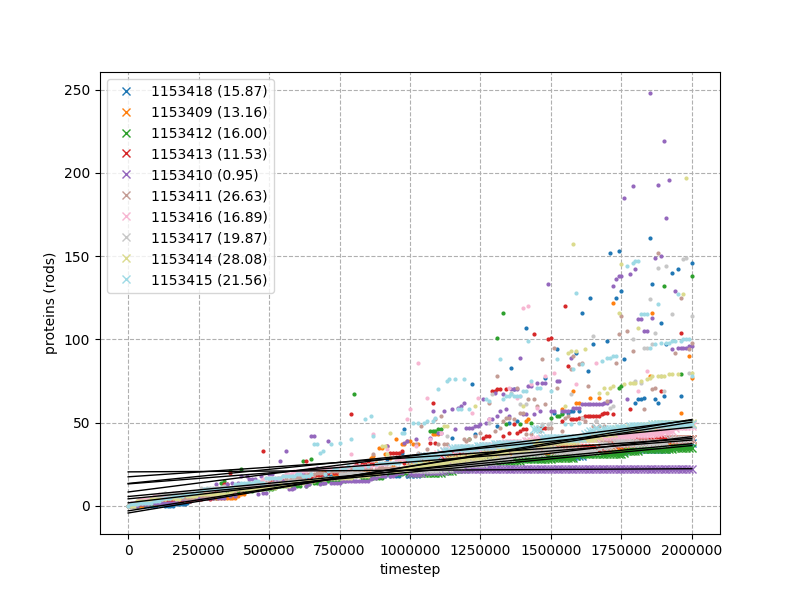

<IPython.core.display.Javascript object>


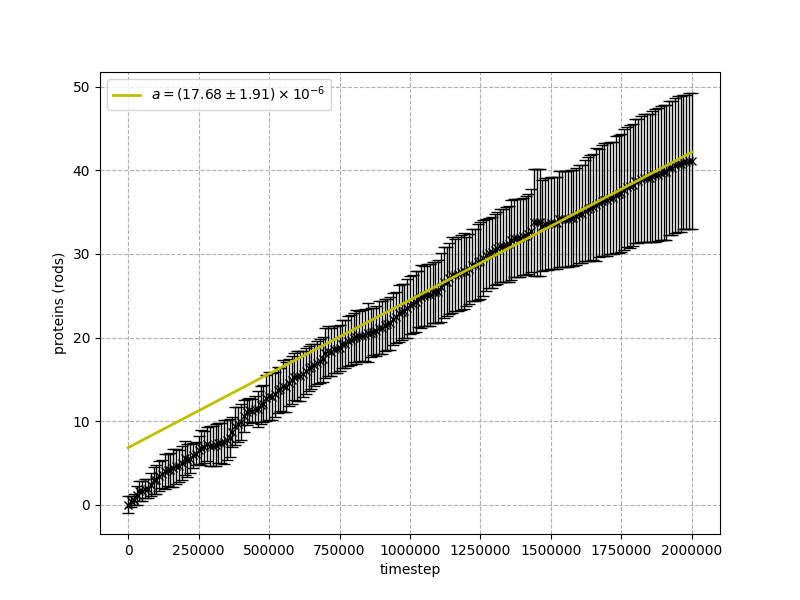

In [144]:
# what simulations to draw
cell_size = cell_sizes[0]
num_cells = nums_cells[0]
try:
    key = (cell_size, num_cells)
    data = all_data[key]
except KeyError:
    print "ERROR: No simulations with those parameters!"
    assert False

# draw growth
fig = plt.figure('Growth by simulation ({:.1f}, {:.1f})'.format(*key), figsize=(8,6))
ax = plt.axes()
n = 0
n_sims = len(all_data[key])
for tag, data in all_data[key].iteritems():
    color = cm.tab20(1.*n/(n_sims-1)); n += 1
    xs = data[0][start:end]
    ys = data[3][start:end]
    a, b, _, _, sigma = linregress(xs, ys)
    ax.plot(data[0], data[2], '.', c=color, markersize=4)
    ax.plot(xs, ys, 'x', c=color, label=r'%s (%.2f)' % (tag, a*10**6))
    ax.plot(data[0], a*data[0] + b, '-', lw=1.0, c='black', zorder=5)
ax.set_xlabel(r'timestep')
ax.set_ylabel(r'proteins (rods)')
ax.legend(loc='upper left')
ax.grid(linestyle='--')

common_ts, growth_avgs, growth_stds, growth_rate, intercept, conc = growth_stats[key]
fig = plt.figure('Averaged growth ({:.1f}, {:.1f})'.format(*key), figsize=(8,6))
ax = plt.axes()
ax.errorbar(common_ts, growth_avgs, yerr=growth_stds, fmt='xk', capsize=4, lw=1.0)
ax.plot(common_ts, growth_rate[0]*common_ts + intercept[0], '-y', lw=2.0, zorder=5,
        label=r'$a = (%.2f \pm %.2f) \times 10^{-6}$' % ((growth_rate[0]*10**6), (growth_rate[1]*10**6)))
ax.set_xlabel(r'timestep')
ax.set_ylabel(r'proteins (rods)')
ax.legend(loc='upper left')
ax.grid(linestyle='--')

plt.show()

<IPython.core.display.Javascript object>


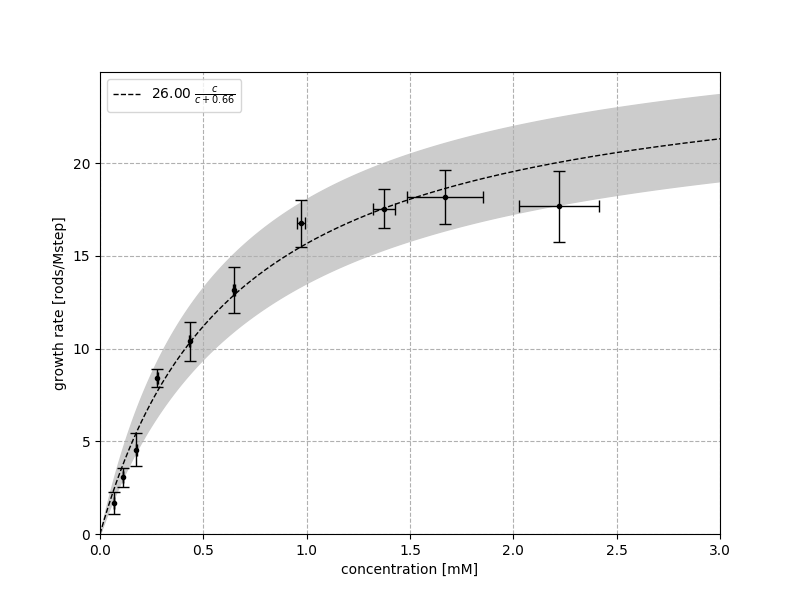

In [147]:
# draw growth vs. concentration
xs = []
xdevs = []
ys = []
ydevs = []
for key in growth_stats.keys():
    cell_size, num_cells = key
    common_ts, avgs, stds, rate, intercept, conc = growth_stats[key]
    if conc[0]==0.0 or rate[0]==0.0:
        continue
    xs.append(conc[0])
    xdevs.append(conc[1])
    ys.append(rate[0]*10**6)
    ydevs.append(rate[1]*10**6)
xs = np.array(xs); xdevs = np.array(xdevs)
ys = np.array(ys); ydevs = np.array(ydevs)

growth_model = scipy.odr.Model(growth_fit_func)
data = scipy.odr.RealData(xs, ys, xdevs, ydevs)
out = scipy.odr.ODR(data, growth_model, beta0=[0.5, 20.0]).run()
ct, vmax = out.beta
sd_ct, sd_vmax = out.sd_beta

fig = plt.figure('Growth rate', figsize=(8,6))
ax = plt.axes()
ax.errorbar(xs, ys, xerr=xdevs, yerr=ydevs, fmt='.k', capsize=4, lw=1.0)
cs = np.linspace(0, 3.0, 300)
mid = growth_fit_func([ct, vmax], cs)
top = growth_fit_func([ct-sd_ct, vmax+sd_vmax], cs)
bottom = growth_fit_func([ct+sd_ct, vmax-sd_vmax], cs)
ax.plot(cs, mid, '--k', lw=1.0, label=r'$%.2f\;\frac{c}{c %+.2f}$' % (vmax, ct))
ax.fill_between(cs, mid, top, color=str(0.8))
ax.fill_between(cs, bottom, mid, color=str(0.8))
ax.set_xlabel(r'concentration [mM]')
ax.set_xlim(0.0, 3.0)
ax.set_ylabel(r'growth rate [rods/Mstep]')
ax.set_ylim(0.0)
ax.grid(linestyle='--')
ax.legend(loc='upper left')

plt.show()

<IPython.core.display.Javascript object>


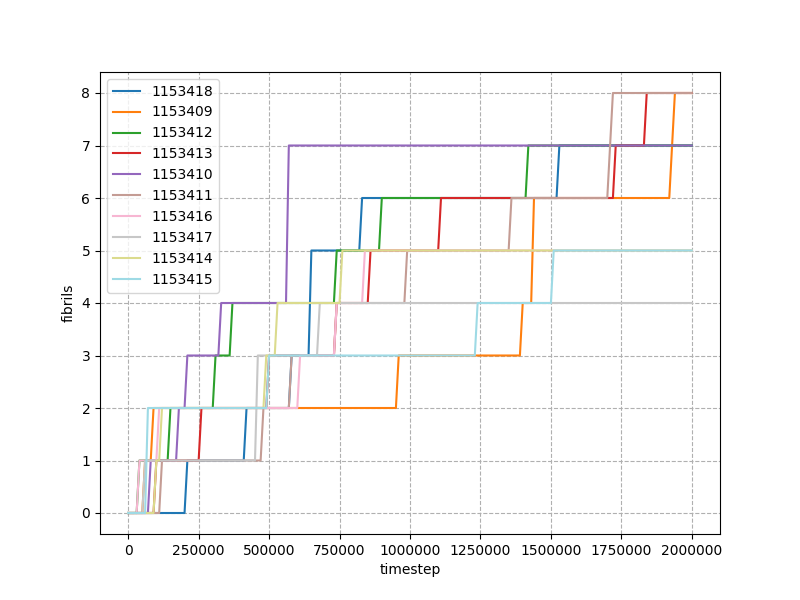

<IPython.core.display.Javascript object>


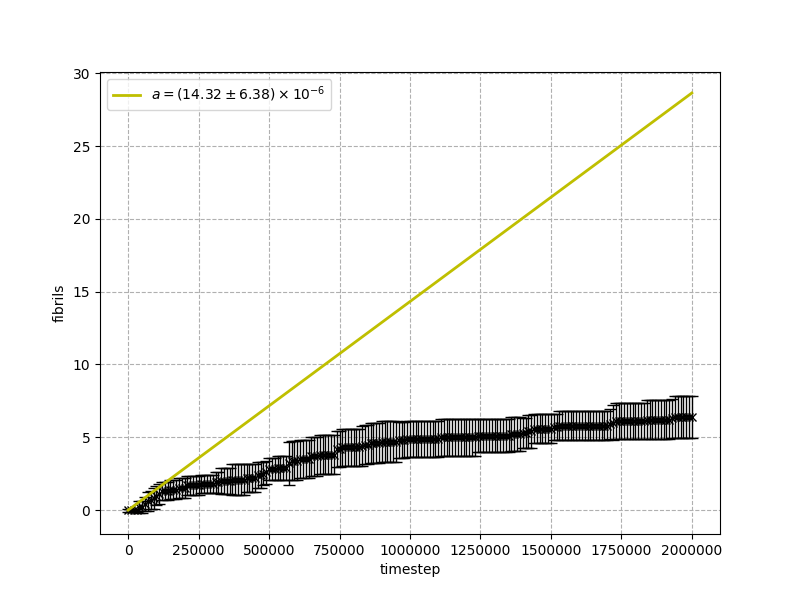

In [125]:
# what simulations to draw
cell_size = cell_sizes[0]
num_cells = nums_cells[0]
try:
    key = (cell_size, num_cells)
    data = all_data[key]
except KeyError:
    print "ERROR: No simulations with those parameters!"
    assert False

# draw nucleation
fig = plt.figure('Nucleation by simulation ({:.1f}, {:.1f})'.format(*key), figsize=(8,6))
ax = plt.axes()
n = 0
n_sims = len(all_data[key])
for tag, data in all_data[key].iteritems():
    color = cm.tab20(1.*n/(n_sims-1)); n += 1
    ax.plot(data[0], data[6]-1, '-', c=color, label=r'{:s}'.format(tag))
ax.set_xlabel(r'timestep')
ax.set_ylabel(r'fibrils')
ax.legend(loc='upper left')
ax.grid(linestyle='--')

common_ts, nucl_avgs, nucl_stds, nucl_rate, nucl_conc = nucl_stats[key]
fig = plt.figure('Averaged nucleation ({:.1f}, {:.1f})'.format(*key), figsize=(8,6))
ax = plt.axes()
ax.errorbar(common_ts, nucl_avgs, yerr=nucl_stds, fmt='xk', capsize=4, lw=1.0)
ax.plot(common_ts, nucl_rate[0]*common_ts, '-y', lw=2.0, zorder=5,
        label=r'$a = (%.2f \pm %.2f) \times 10^{-6}$' % ((nucl_rate[0]*10**6), (nucl_rate[1]*10**6)))
ax.set_xlabel(r'timestep')
ax.set_ylabel(r'fibrils')
ax.legend(loc='upper left')
ax.grid(linestyle='--')

plt.show()

In [157]:
# draw nucleation vs. concentration
xs = []
xdevs = []
ys = []
ydevs = []
for key in nucl_stats.keys():
    cell_size, num_cells = key
    common_ts, avgs, stds, rate, conc = nucl_stats[key]
    if conc[0]==0.0 or rate[0]==0.0:
        continue
    xs.append(np.log(conc[0]))
    xdevs.append(conc[1]/conc[0])
    ys.append(np.log(rate[0]))
    ydevs.append(rate[1]/rate[0])
xs = np.array(xs); xdevs = np.array(xdevs)
ys = np.array(ys); ydevs = np.array(ydevs)

nucl_model = scipy.odr.Model(nucl_fit_func)
data = scipy.odr.RealData(xs, ys, xdevs, ydevs)
out = scipy.odr.ODR(data, nucl_model, beta0=[2.0, -15.0]).run()
nc, loga = out.beta
sd_nc, sd_loga = out.sd_beta

fig = plt.figure('Nucleation rate', figsize=(8,6))
ax = plt.axes()
ax.errorbar(xs, ys, xerr=xdevs, yerr=ydevs, fmt='.k', capsize=4, lw=1.0)
logcs = np.linspace(-3.0, 1.5, 45)
mid = nucl_fit_func([nc, loga], logcs)
top = nucl_fit_func([nc+sd_nc, loga-sd_loga], logcs)
bottom = nucl_fit_func([nc-sd_nc, loga+sd_loga], logcs)
ax.plot(logcs, mid, '--k', lw=1.0, label=r'$%.2f\;log(c) %+.2f$' % (nc, loga))
ax.fill_between(logcs, mid, top, color=str(0.8))
ax.fill_between(logcs, bottom, mid, color=str(0.8))
ax.set_xlabel(r'log(c) [log(mM)]')
ax.set_xlim(-3.0, 1.5)
ax.set_ylabel(r'log(r) [log(fibrils/step)]')
#ax.set_ylim(-19.0, -13.0)
ax.grid(linestyle='--')
ax.legend(loc='upper left')

plt.show()

<IPython.core.display.Javascript object>